# 示例：剩余使用寿命预测

In [1]:
from rulframework.data.FeatureExtractor import FeatureExtractor
from rulframework.data.loader.XJTUDataLoader import XJTUDataLoader
from rulframework.data.label.RulLabelGenerator import RulLabelGenerator
from rulframework.data.processor.RMSProcessor import RMSProcessor
from rulframework.model.pytorch.PytorchModel import PytorchModel
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.model.pytorch.basic.CNN import CNN
from rulframework.metric.Evaluator import Evaluator
from rulframework.metric.end2end.End2EndMAE import End2EndMAE
from rulframework.metric.end2end.End2EndMSE import End2EndMSE
from rulframework.metric.end2end.End2EndRMSE import End2EndRMSE
from rulframework.util.Plotter import Plotter

# 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTUDataLoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, data_loader.continuum)

DEBUG - 16:55:39 >> 
>> 数据集位置：D:\data\dataset\XJTU-SY_Bearing_Datasets
  Bearing1_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
  Bearing1_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
  Bearing1_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
  Bearing1_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
  Bearing1_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
  Bearing2_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
  Bearing2_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
  Bearing2_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
  Bearing2_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
  Bearing2_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
  Bearing3_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40Hz10kN\Bearing3_1
  Bearing3_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40H

# 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader.get("Bearing1_3", 'Horizontal Vibration')
feature_extractor.extract(bearing)
stage_calculator.calculate_state(bearing)

DEBUG - 16:55:39 >> 正在加载数据项：Bearing1_3
DEBUG - 16:55:40 >> 成功加载数据项：Bearing1_3


# 生成训练数据

In [4]:
generator = RulLabelGenerator(2048, is_from_fpt=False, is_rectified=True)
data_set = generator.generate(bearing)
train_set, test_set = data_set.split(0.7)

# 定义模型并训练

INFO - 16:55:40 >> 
>> 成功初始化模型
  当前使用设备：cuda
  模型参数类型：torch.float32
DEBUG - 16:55:41 >> Epoch 1/10, Loss: 0.2053342637
DEBUG - 16:55:41 >> Epoch 2/10, Loss: 0.0218689129
DEBUG - 16:55:41 >> Epoch 3/10, Loss: 0.0060725524
DEBUG - 16:55:41 >> Epoch 4/10, Loss: 0.0039925404
DEBUG - 16:55:41 >> Epoch 5/10, Loss: 0.0031170252
DEBUG - 16:55:41 >> Epoch 6/10, Loss: 0.0026361841
DEBUG - 16:55:41 >> Epoch 7/10, Loss: 0.0023617153
DEBUG - 16:55:41 >> Epoch 8/10, Loss: 0.0022281639
DEBUG - 16:55:41 >> Epoch 9/10, Loss: 0.0020414095
DEBUG - 16:55:41 >> Epoch 10/10, Loss: 0.0018762667


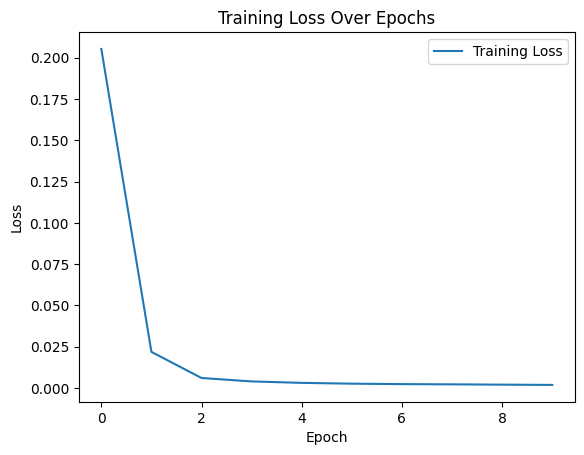

In [5]:
model = PytorchModel(CNN(2048, 1))
model.train(train_set, 10, weight_decay=0.01)
Plotter.loss(model)

# 做出预测

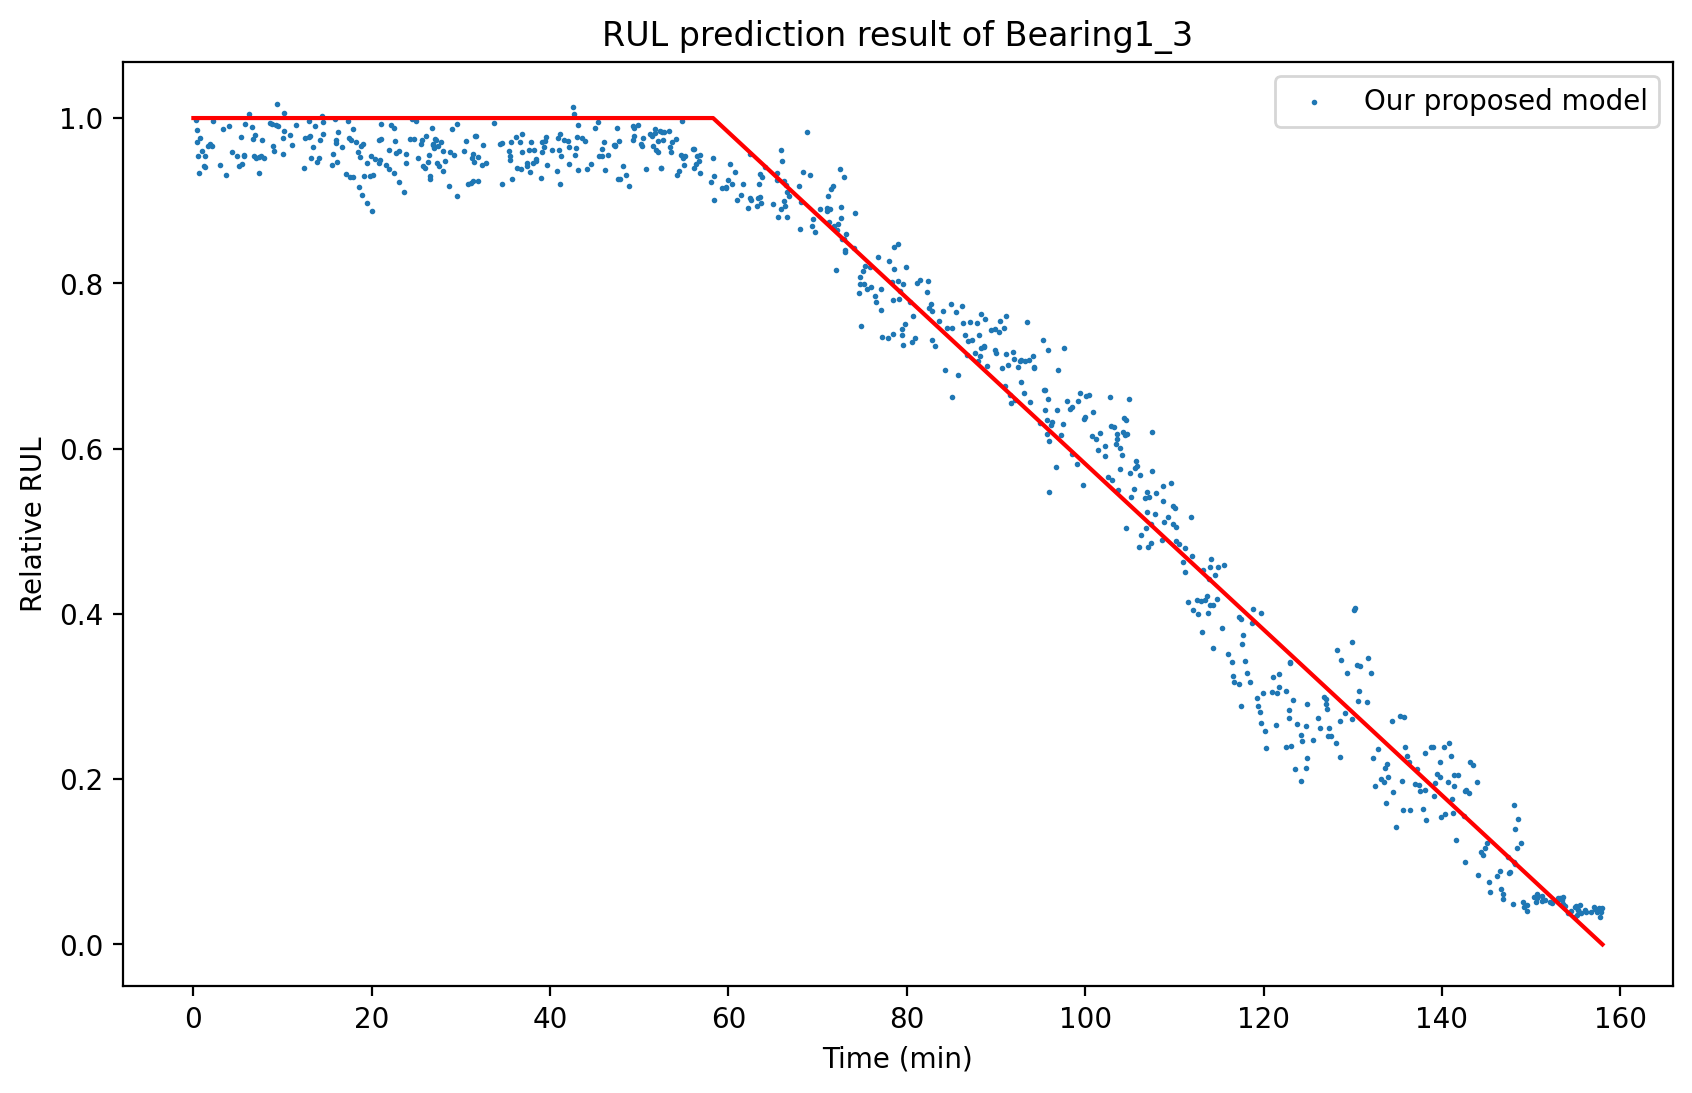

In [6]:
result = model.test(test_set)
Plotter.rul_end2end(test_set, result)

# 预测结果评价

In [7]:
evaluator = Evaluator()
evaluator.add(End2EndMAE(), End2EndMSE(), End2EndRMSE())
evaluator(test_set, result)

INFO - 16:55:41 >> 
轴承Bearing1_3的预测结果评价：
  MAE： 0.0397
  MSE： 0.0023
  RMSE： 0.0477
